In [52]:
import torch
import torch.nn as nn
import torch.optim as optim

import seaborn as sns
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import math


from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

from scipy.signal import savgol_filter
from scipy.signal import medfilt


import os
from torch.utils.data import DataLoader as DataLoader
from torch.utils.data import Dataset as Dataset
from torch.nn.functional import interpolate

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [54]:
torch.set_default_dtype(torch.float64)

In [55]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN,self).__init__()
        self.net = nn.Sequential(nn.Linear(3,64),
                                 nn.Tanh(),
                                 nn.Linear(64,64),
                                 nn.Tanh(),
                                 nn.Linear(64,1))
        
    def forward(self,x):
        return self.net(x)

In [56]:
def initial_condition(x,y):
    return torch.sin(torch.pi*x) * torch.sin(torch.pi*y)

In [57]:
def boundary_condition(x,y,t, custom_value):
    return torch.full_like(x, custom_value).to(device)
    

In [58]:
def generate_training_data(num_points):
    x = torch.rand(num_points, 1, requires_grad = True).to(device)
    y = torch.rand(num_points, 1, requires_grad = True).to(device)
    t = torch.rand(num_points, 1, requires_grad = True).to(device)
    
    return x, y, t


In [59]:
def generate_boundary_points(num_points):
    x_boundary = torch.tensor([0.0,1.0]).repeat(num_points//2).to(device)
    y_boundary = torch.rand(num_points).to(device)
    
    if torch.rand(1) > 0.5:
        x_boundary, y_boundary = y_boundary, x_boundary
        
    return x_boundary.view(-1,1), y_boundary.view(-1,1)

In [60]:
def generate_boundary_training_data(num_points):
    x_boundary, y_boundary = generate_boundary_points(num_points)
    t = torch.rand(num_points, 1, requires_grad=True).to(device)
    
    return x_boundary, y_boundary, t

In [61]:
def pde(x,y,t,model):
    input_data = torch.cat([x,y,t],dim=1)
    u = model(input_data)
    u_x,u_y = torch.autograd.grad(u,[x,y],grad_outputs= torch.ones_like(u), create_graph= True, retain_graph=True) 
    u_xx = torch.autograd.grad(u_x,x,grad_outputs= torch.ones_like(u_x), create_graph= True, retain_graph=True)[0]
    u_yy = torch.autograd.grad(u_y,y,grad_outputs= torch.ones_like(u_y), create_graph= True, retain_graph=True)[0]
    u_t = torch.autograd.grad(u,t,grad_outputs= torch.ones_like(u), create_graph= True, retain_graph=True)[0]
    heat_eq_residual = 1 * u_xx + 1 * u_yy - u_t
    return heat_eq_residual

In [62]:
def train_PINN(model, num_iterations, num_points):
    optimiser = optim.Adam(model.parameters(), lr=1e-03)
    
    for iteration in range(num_iterations):
        optimiser.zero_grad()
        
        x,y,t = generate_training_data(num_points)
        
        x_b, y_b, t_b = generate_boundary_training_data(num_points)
        
        t_initial = torch.zeros_like(x)
        u_initial = initial_condition(x,y)
        
        custom_value = 0
        u_boundary_x = boundary_condition(x_b,y_b,t_b,custom_value)
        u_boundary_y = boundary_condition(y_b,x_b,t_b,custom_value)
        
        residual = pde(x,y,t,model)
        
        loss =  nn.MSELoss()(u_initial, model(torch.cat([x,y,t_initial], dim=1))) + \
                nn.MSELoss()(u_boundary_x, model(torch.cat([x_b,y_b,t_b], dim=1))) + \
                nn.MSELoss()(u_boundary_y, model(torch.cat([y_b,x_b,t_b], dim=1))) + \
                nn.MSELoss()(residual, torch.zeros_like(residual))
                
        loss.backward()
        optimiser.step()
        
        if iteration % 100 ==0:
            print(f"itration:, {iteration}, loss:, {loss}" )

In [63]:
model = PINN().to(device)
num_iterations = 10000
num_points = 1000
train_PINN(model,num_iterations,num_points)

itration:, 0, loss:, 0.3231252237610772
itration:, 100, loss:, 0.12795492154124624
itration:, 200, loss:, 0.12708618308373532
itration:, 300, loss:, 0.09928475677201867
itration:, 400, loss:, 0.08460275902028952
itration:, 500, loss:, 0.07032221316748084
itration:, 600, loss:, 0.06303063322656534
itration:, 700, loss:, 0.05904908011124002
itration:, 800, loss:, 0.053279358650161014
itration:, 900, loss:, 0.04809244652510252
itration:, 1000, loss:, 0.04277270825301498
itration:, 1100, loss:, 0.03991453959346694
itration:, 1200, loss:, 0.0378989593275644
itration:, 1300, loss:, 0.03717798657207501
itration:, 1400, loss:, 0.033975356083507116
itration:, 1500, loss:, 0.02995056763304567
itration:, 1600, loss:, 0.0268712041504934
itration:, 1700, loss:, 0.02501110201204278
itration:, 1800, loss:, 0.0238097468273797
itration:, 1900, loss:, 0.02183264846671588
itration:, 2000, loss:, 0.02105449548675599
itration:, 2100, loss:, 0.017898772949957877
itration:, 2200, loss:, 0.018591580607748216


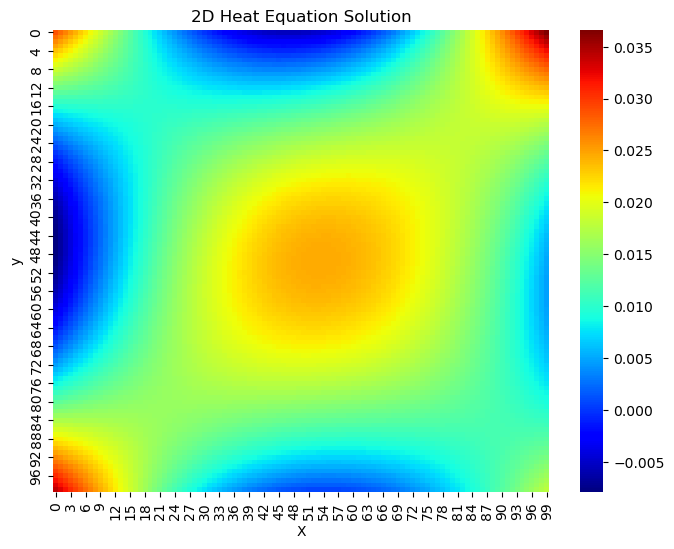

In [83]:
with torch.no_grad():
    x_vals = torch.linspace(0,1,100).to(device)
    y_vals = torch.linspace(0,1,100).to(device)
    X, Y = torch.meshgrid(x_vals,y_vals)
    t_val = torch.ones_like(X) * 0.2# spacify the time
    
    input_data = torch.stack([X.flatten(),Y.flatten(),t_val.flatten()], dim=1)
    solution = model(input_data).reshape(X.shape,Y.shape)
    
    plt.figure(figsize=(8,6))
    sns.heatmap(solution.cpu().detach().numpy(), cmap="jet")
    plt.title("2D Heat Equation Solution")
    plt.xlabel("X")
    plt.ylabel("y")
    plt.show()

In [82]:
solution = model(input_data)
print(solution)

tensor([[0.0221],
        [0.0213],
        [0.0205],
        ...,
        [0.0008],
        [0.0010],
        [0.0013]], device='cuda:0', grad_fn=<AddmmBackward0>)
